In [2]:
%matplotlib inline

import os
import tqdm
import json

import catboost
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from importlib import reload
import common
reload(common)
from common import (plot_features_target_correlation, plot_learning_curve, join_dataframes, 
                    get_sorted_factors, calculate_eval_metrics, plot_feature_importance, 
                    get_technical_indicators_df, plot_eval_metrics)

# SP 500 symbols

In [3]:
with open('../sp_500_symbols.txt', 'r') as f:
    sp_500_symbols = f.read().split('\n')[:-1]
    
len(sp_500_symbols)

505

# Data

In [4]:
tech_ind_dir = '/home/artem/Documents/Programming/ML-DS/AlgorithmicTrading/tech_ind_data_202012'

In [5]:
def read_df(tech_ind_dir_path, tech_ind_postfix, symbols):
    df = pd.DataFrame()
    for s in tqdm.tqdm(symbols):
        tech_ind_df_path = os.path.join(tech_ind_dir_path, s + tech_ind_postfix)
        if not os.path.exists(tech_ind_df_path):
            print('No tech indices for {}'.format(s))
            continue
        tech_ind_df = pd.read_csv(tech_ind_df_path)
        tech_ind_df.sort_values('date', inplace=True)
        
        columns = tech_ind_df.columns
        
        columns_to_prev = {c: 'prev_' + c for c in columns}
        columns_to_next = {'mom_1': 'next_mom_1'}
        
        prev_cur_tech_ind_df = tech_ind_df[:-2].copy()
        cur_cur_tech_ind_df = tech_ind_df[1:-1].copy()
        next_cur_tech_ind_df = tech_ind_df[2:].copy()
        
        prev_cur_tech_ind_df.rename(columns=columns_to_prev, inplace=True)
        next_cur_tech_ind_df.rename(columns=columns_to_next, inplace=True)
        
        prev_cur_tech_ind_df.reset_index(drop=True, inplace=True)
        cur_cur_tech_ind_df.reset_index(drop=True, inplace=True)
        next_cur_tech_ind_df.reset_index(drop=True, inplace=True)
        
        cur_cur_tech_ind_df = pd.concat(
            [cur_cur_tech_ind_df, prev_cur_tech_ind_df, next_cur_tech_ind_df['next_mom_1']], 
            axis=1)

        df = df.append(cur_cur_tech_ind_df, ignore_index=True, sort=False)
    
    return df

In [6]:
df = read_df(tech_ind_dir, '_tech_ind.csv', sp_500_symbols)
df

 16%|█▋        | 83/505 [00:14<02:01,  3.46it/s]

No tech indices for BF.B


 19%|█▉        | 96/505 [00:17<02:00,  3.39it/s]

No tech indices for CBS


100%|██████████| 505/505 [04:29<00:00,  1.03it/s]


,date,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,...,prev_mfi_14,prev_chaikin_a/d,prev_obv,prev_bbands_14_up,prev_bbands_14_mid,prev_bbands_14_low,prev_bbands_7_mid,prev_bbands_7_up,prev_bbands_7_low,next_mom_1
0,2000-01-13,29.0948,28.9555,28.2901,0.0000,1.8926,2.5028,60.6273,58.5058,80.6800,...,70.5607,-1.193372e+07,24565000.0,30.8074,28.6984,26.5893,29.1879,31.6104,26.7654,-0.4392
1,2000-01-14,29.2563,29.0106,28.3503,-0.4392,2.5588,1.8425,52.8857,54.7953,76.7232,...,65.0705,-1.298110e+07,24565000.0,30.9059,28.8613,26.8168,29.6162,30.9598,28.2726,-0.6426
2,2000-01-18,29.4692,29.0022,28.3893,-0.6426,0.5542,0.9964,43.4215,49.8172,71.3575,...,59.1981,-1.456324e+07,22023200.0,30.9139,28.9784,27.0429,29.7872,30.4231,29.1513,0.4953
3,2000-01-19,29.5858,29.0573,28.4445,0.4953,-0.5866,0.5690,51.2631,53.3356,65.5783,...,54.2432,-1.667804e+07,19908400.0,30.9150,28.9837,27.0524,29.6326,30.6654,28.5998,-1.0848
4,2000-01-20,29.4001,28.9950,28.4603,-1.0848,-2.2611,-0.6987,37.8551,45.7663,57.2766,...,55.0692,-1.676205e+07,22536600.0,30.9390,29.0113,27.0835,29.4646,30.3816,28.5477,-0.0560
5,2000-01-21,29.1426,29.0077,28.4688,-0.0560,-2.1697,-0.4245,37.2680,45.4079,50.2236,...,49.2133,-1.906505e+07,19432000.0,30.9543,28.9849,27.0155,29.1627,30.3269,27.9984,-0.6456
6,2000-01-24,28.8298,29.0558,28.4404,-0.6456,-2.2846,-1.5123,30.8363,41.3859,39.7368,...,43.2916,-2.184997e+07,14940200.0,30.9583,28.9230,26.8877,28.9285,30.2709,27.5861,-0.4039
7,2000-01-25,28.5311,28.9680,28.4142,-0.4039,-2.7770,-0.8844,27.3869,39.0554,29.9066,...,42.6053,-2.322885e+07,11969200.0,31.0114,28.8887,26.7660,28.5895,30.1473,27.0317,1.4533
8,2000-01-26,28.3840,28.8662,28.4276,1.4533,-1.3236,1.6744,50.5911,49.9728,23.2571,...,41.7627,-2.511830e+07,8278000.0,30.9647,28.9045,26.8443,28.1928,29.8149,26.5707,-0.0177
9,2000-01-27,28.2350,28.7176,28.4592,-0.0177,-0.9021,0.2948,50.3626,49.8557,24.8517,...,45.6723,-2.572741e+07,15298800.0,30.9573,28.9268,26.8963,28.0664,29.4519,26.6809,-1.1792


# Inspect data

In [7]:
df.shape

(2382797, 59)

In [8]:
df.columns

Index(['date', 'sma_9', 'sma_13', 'sma_26', 'mom_1', 'mom_8', 'mom_15',
       'rsi_7', 'rsi_14', 'slowd', 'slowk', 'dema_13', 'dema_26', 'adx_7',
       'adx_14', 'cci_7', 'cci_14', 'aroon_up', 'aroon_down', 'mfi_7',
       'mfi_14', 'chaikin_a/d', 'obv', 'bbands_14_up', 'bbands_14_mid',
       'bbands_14_low', 'bbands_7_mid', 'bbands_7_up', 'bbands_7_low',
       'prev_date', 'prev_sma_9', 'prev_sma_13', 'prev_sma_26', 'prev_mom_1',
       'prev_mom_8', 'prev_mom_15', 'prev_rsi_7', 'prev_rsi_14', 'prev_slowd',
       'prev_slowk', 'prev_dema_13', 'prev_dema_26', 'prev_adx_7',
       'prev_adx_14', 'prev_cci_7', 'prev_cci_14', 'prev_aroon_up',
       'prev_aroon_down', 'prev_mfi_7', 'prev_mfi_14', 'prev_chaikin_a/d',
       'prev_obv', 'prev_bbands_14_up', 'prev_bbands_14_mid',
       'prev_bbands_14_low', 'prev_bbands_7_mid', 'prev_bbands_7_up',
       'prev_bbands_7_low', 'next_mom_1'],
      dtype='object')

In [9]:
df.sort_values(by='date', inplace=True)

In [10]:
df[-10:]

,date,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,...,prev_mfi_14,prev_chaikin_a/d,prev_obv,prev_bbands_14_up,prev_bbands_14_mid,prev_bbands_14_low,prev_bbands_7_mid,prev_bbands_7_up,prev_bbands_7_low,next_mom_1
1382811,2020-12-23,41.0256,41.5662,41.0088,1.64,-1.60,0.7300,53.6007,55.5255,27.1381,...,45.9871,6.566340e+07,381792851.0,44.1357,41.6393,39.1428,40.7157,42.4735,38.9579,-0.10
1388082,2020-12-23,128.5811,129.6138,128.1577,2.35,0.10,-0.1100,50.3435,56.2605,29.9424,...,34.7506,3.099950e+08,298257975.0,135.3996,130.3071,125.2147,128.5871,132.0032,125.1711,0.14
376224,2020-12-23 00:00:00,38.2067,38.5054,38.6046,0.51,3.10,1.0100,63.0964,56.3198,66.6172,...,49.9316,3.575206e+08,47342359.0,40.6001,38.5364,36.4728,38.2457,40.0184,36.4730,-0.66
381495,2020-12-23 00:00:00,97.3611,98.6954,99.6427,-0.29,-7.38,-8.4500,25.7070,42.2216,11.1182,...,33.1743,2.960402e+08,110118543.0,106.6753,99.9350,93.1947,97.6671,103.8504,91.4839,1.33
334057,2020-12-23 00:00:00,245.6567,243.7113,238.8157,-1.65,1.56,3.2137,50.6732,54.3326,75.4580,...,67.7817,3.806138e+08,338108640.0,251.8779,243.1149,234.3518,246.2814,253.3442,239.2187,3.74
349869,2020-12-23 00:00:00,247.8722,246.8223,245.3181,3.33,9.77,4.2800,63.1006,51.8198,65.4767,...,70.1589,1.582999e+08,369074486.0,251.3935,246.2464,241.0994,248.3171,251.2632,245.3711,-2.31
360411,2020-12-23 00:00:00,15.6600,15.9446,17.0897,0.41,-0.34,-2.6299,36.7303,37.7222,8.1929,...,11.7556,3.510934e+08,352884985.0,18.1351,16.2703,14.4055,15.6371,16.3094,14.9649,-0.10
355140,2020-12-23 00:00:00,697.3856,699.9977,696.0312,10.12,8.44,-11.0935,56.2880,57.4498,40.6900,...,35.5299,1.051658e+08,169099983.0,717.0419,701.0871,685.1324,696.8043,709.3164,684.2922,3.54
312974,2020-12-23 00:00:00,91.8167,92.6431,94.2252,-0.88,-0.97,-2.3900,41.4344,44.8782,30.8507,...,48.0731,7.969943e+08,824610290.0,95.8895,92.8250,89.7605,91.7371,93.5391,89.9352,0.73
323516,2020-12-23 00:00:00,79.5722,79.2546,78.0810,0.09,-0.59,2.6443,45.9007,49.7579,68.1623,...,59.2272,8.456396e+08,652163915.0,81.3952,78.9914,76.5877,79.7229,81.4949,77.9509,0.84


In [11]:
df[10:][['rsi_7', 'prev_rsi_7']]

,rsi_7,prev_rsi_7
1641814,49.6927,50.2022
1636543,66.0708,57.7991
1631272,21.0718,18.5346
1626001,46.9612,35.5797
1620730,52.6964,39.6951
1609267,53.6405,53.6405
1603996,69.5042,51.5856
1598725,64.0808,55.9698
137964,64.3417,60.8875
1593454,23.1316,31.1730


In [12]:
# dates, symbols_cnt = df.date.unique(), df.groupby('date').date.count().values

In [13]:
# plt.plot(dates, symbols_cnt)

In [14]:
df.groupby('date').date.count()

date
2000-01-13             381
2000-01-14             381
2000-01-18             381
2000-01-19             381
2000-01-20             381
2000-01-21             381
2000-01-24             381
2000-01-25             382
2000-01-26             382
2000-01-27             382
2000-01-28             382
2000-01-31             382
2000-02-01             382
2000-02-02             383
2000-02-03             383
2000-02-04             383
2000-02-07             383
2000-02-08             383
2000-02-09             383
2000-02-10             383
2000-02-11             383
2000-02-14             383
2000-02-15             383
2000-02-16             383
2000-02-17             383
2000-02-18             383
2000-02-22             383
2000-02-23             383
2000-02-24             383
2000-02-25             383
                      ... 
2020-12-03             466
2020-12-03 00:00:00      8
2020-12-04             466
2020-12-04 00:00:00      8
2020-12-07             466
2020-12-07 00:00:00    

In [15]:
df[['mom_1', 'next_mom_1']].tail(10)

,mom_1,next_mom_1
1382811,1.64,-0.10
1388082,2.35,0.14
376224,0.51,-0.66
381495,-0.29,1.33
334057,-1.65,3.74
349869,3.33,-2.31
360411,0.41,-0.10
355140,10.12,3.54
312974,-0.88,0.73
323516,0.09,0.84


In [16]:
df.isnull().any().any()

False

# Prepare training data

In [17]:
min_date = '2010-01-01'

In [18]:
df_filtered = df[df.date > min_date]

In [19]:
df_filtered.shape

(1321605, 59)

In [20]:
test_samples = 50000

min_test_date = df_filtered.iloc[-test_samples].date
min_test_date

'2020-07-27'

In [21]:
df_test = df_filtered[df_filtered.date >= min_test_date].copy()
df_train = df_filtered[df_filtered.date < min_test_date].copy()

In [22]:
df_test.date.min(), df_train.date.max()

('2020-07-27', '2020-07-24 00:00:00')

In [23]:
df_test['target'] = df_test['next_mom_1'] / df_test['sma_9']
df_test.drop(['date', 'prev_date', 'next_mom_1'], axis=1, inplace=True)
# df_test.drop(['next_mom_1'], axis=1, inplace=True)

df_train['target'] = df_train['next_mom_1'] / df_train['sma_9']
df_train.drop(['date', 'prev_date', 'next_mom_1'], axis=1, inplace=True)

In [24]:
df_test.shape, df_train.shape

((50359, 57), (1271246, 57))

In [25]:
df_train.drop(df_train[abs(df_train['target']) > 0.1].index, inplace=True)
# df_test.drop(df_test[abs(df_test['target']) > 0.1].index, inplace=True)

In [26]:
df_test.shape, df_train.shape

((50359, 57), (1266941, 57))

# Analyze trainig data

In [27]:
df_test['target'].mean(), df_train['target'].mean()

(0.0018978103136360405, 0.0005884692874422792)

In [28]:
df_train.columns

Index(['sma_9', 'sma_13', 'sma_26', 'mom_1', 'mom_8', 'mom_15', 'rsi_7',
       'rsi_14', 'slowd', 'slowk', 'dema_13', 'dema_26', 'adx_7', 'adx_14',
       'cci_7', 'cci_14', 'aroon_up', 'aroon_down', 'mfi_7', 'mfi_14',
       'chaikin_a/d', 'obv', 'bbands_14_up', 'bbands_14_mid', 'bbands_14_low',
       'bbands_7_mid', 'bbands_7_up', 'bbands_7_low', 'prev_sma_9',
       'prev_sma_13', 'prev_sma_26', 'prev_mom_1', 'prev_mom_8', 'prev_mom_15',
       'prev_rsi_7', 'prev_rsi_14', 'prev_slowd', 'prev_slowk', 'prev_dema_13',
       'prev_dema_26', 'prev_adx_7', 'prev_adx_14', 'prev_cci_7',
       'prev_cci_14', 'prev_aroon_up', 'prev_aroon_down', 'prev_mfi_7',
       'prev_mfi_14', 'prev_chaikin_a/d', 'prev_obv', 'prev_bbands_14_up',
       'prev_bbands_14_mid', 'prev_bbands_14_low', 'prev_bbands_7_mid',
       'prev_bbands_7_up', 'prev_bbands_7_low', 'target'],
      dtype='object')

In [29]:
# plot_features_target_correlation(df_train, 'train', 'target')

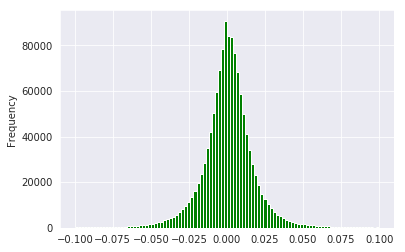

In [30]:
sns.set_style('darkgrid')
df_train['target'].plot(kind='hist', bins=100, color='g')

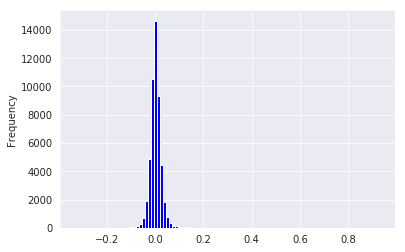

In [31]:
df_test['target'].plot(kind='hist', bins=100, color='b')

# Train model

In [32]:
def prepare_train_val(df, train_fr=0.9, should_print=True):
    train_data_size = int(len(df) * train_fr)
    if should_print:
        print('Train size: {} | Val size: {}'.format(train_data_size, len(df) - train_data_size))
#     df_shuffled = df.sample(frac=1)
    
    train = df[:train_data_size]
    val = df[train_data_size:].copy()
    
    return train, val

In [33]:
train, val = prepare_train_val(df_train)
train.head()

Train size: 1140246 | Val size: 126695


,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,slowk,...,prev_mfi_14,prev_chaikin_a/d,prev_obv,prev_bbands_14_up,prev_bbands_14_mid,prev_bbands_14_low,prev_bbands_7_mid,prev_bbands_7_up,prev_bbands_7_low,target
2325160,11.5862,11.5436,11.2075,0.3019,0.3099,0.7760,63.6791,62.9413,44.9114,43.1071,...,61.3877,9.448741e+07,46613500.0,11.8034,11.4809,11.1584,11.5901,11.7495,11.4306,0.021491
2237395,22.7527,22.6520,22.4920,-0.2031,0.1563,0.0468,46.0827,53.4012,67.7778,62.5926,...,47.5375,2.053586e+08,70987100.0,23.1238,22.6519,22.1801,22.8246,23.2107,22.4385,0.004808
39879,39.7548,39.6440,39.2635,-0.0968,-1.1035,0.5978,37.5927,48.8786,54.4589,39.1403,...,59.6020,5.966347e+07,-37896548.0,40.3771,39.6420,38.9069,39.7868,40.4457,39.1279,-0.005843
482968,16.5311,16.2195,16.0183,0.8339,1.0597,1.2161,73.5433,65.0289,82.5998,86.0127,...,50.1570,7.309097e+08,-101500133.0,17.0464,16.0785,15.1105,16.4967,16.6660,16.3274,-0.003152
859730,8.1717,8.1259,7.9337,0.2356,0.2148,0.5197,58.7136,58.3542,60.9474,57.2007,...,64.6574,5.668260e+07,4133400.0,8.3528,8.1029,7.8529,8.1831,8.4287,7.9374,-0.006779


In [122]:
threshold = 0.01
extract_target = lambda df: df.target.apply(lambda x: 1 if x > threshold else 0)
extract_weight = lambda df: df.target.apply(lambda x: 1 + abs(x - threshold) * 20)
# extract_weight = lambda df: df.target.apply(lambda x: 1)

train_x = train.drop(['target'], axis=1)
train_y = extract_target(train)
train_w = extract_weight(train)

val_x = val.drop(['target'], axis=1)
val_y = extract_target(val)
val_w = extract_weight(val)

test_x = df_test.drop(['target'], axis=1)
test_y = extract_target(df_test)
test_w = extract_weight(df_test)

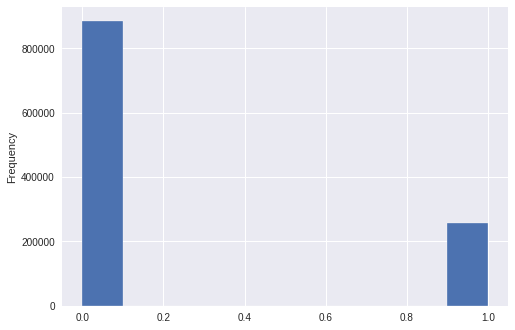

In [123]:
train_y.plot(kind='hist')

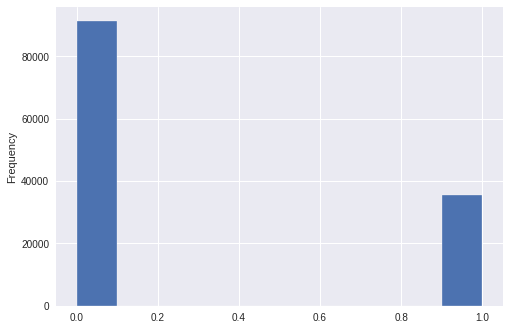

In [124]:
val_y.plot(kind='hist')

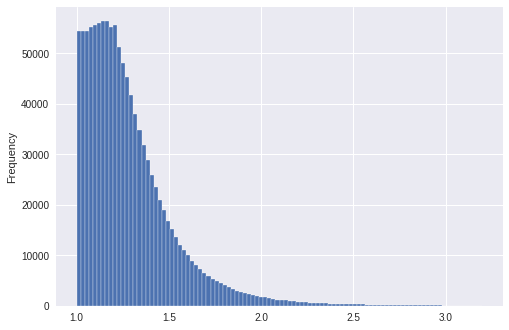

In [125]:
train_w.plot(kind='hist', bins=100)

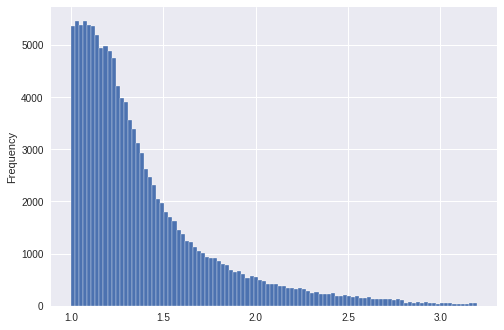

In [126]:
val_w.plot(kind='hist', bins=100)

In [127]:
classifier = CatBoostClassifier(
    iterations=5000, 
    learning_rate=0.02,
    depth=6,
#     l2_leaf_reg=1,
    loss_function='Logloss',
    eval_metric='Logloss',
#     border_count=32,
#     leaf_estimation_iterations=10,
#     leaf_estimation_method='Newton',
    use_best_model=True,
    task_type='CPU'
)
classifier.fit(
    train_x,
    train_y,
    sample_weight=train_w,
    eval_set=Pool(val_x, val_y, weight=val_w),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

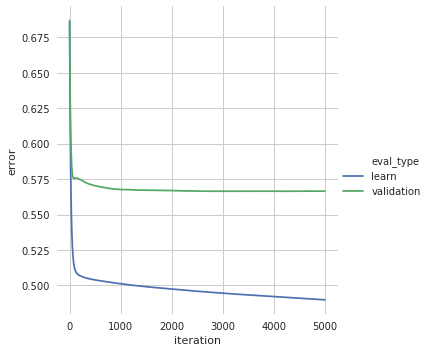

In [128]:
plot_learning_curve(classifier, 'Logloss')

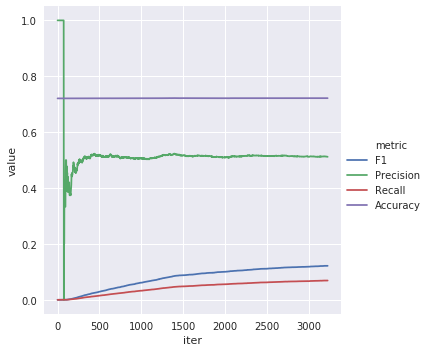

In [129]:
plot_eval_metrics(classifier, val_x, val_y, ['F1', 'Precision', 'Recall', 'Accuracy'])

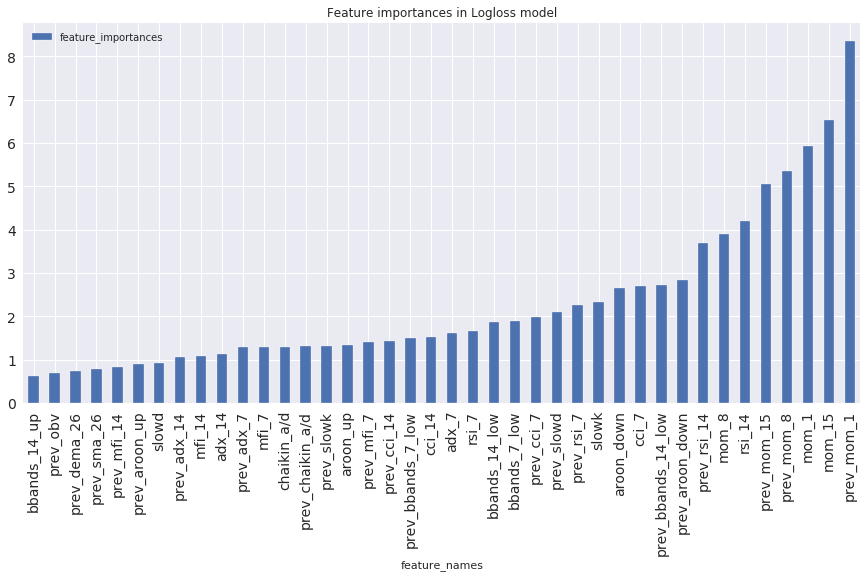

In [130]:
plot_feature_importance(classifier, 'Logloss', 40)

In [131]:
preds = classifier.predict_proba(test_x)
preds[:, 1].mean()

0.24074060532683117

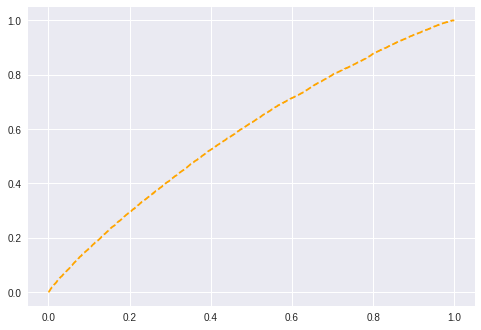

In [132]:
from sklearn import metrics

fpr, tpr, thresh = metrics.roc_curve(test_y, preds[:, 1])

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--', color='orange')

In [133]:
metrics.roc_auc_score(test_y, preds[:, 1])

0.5865601816114687

(array([1.000e+00, 4.000e+00, 4.000e+00, 8.000e+00, 1.200e+01, 1.000e+01,
        7.000e+00, 7.000e+00, 1.500e+01, 1.400e+01, 9.000e+00, 2.500e+01,
        2.600e+01, 3.800e+01, 5.100e+01, 8.400e+01, 1.270e+02, 1.310e+02,
        1.790e+02, 2.910e+02, 3.140e+02, 3.640e+02, 4.270e+02, 5.860e+02,
        6.980e+02, 7.910e+02, 8.560e+02, 9.240e+02, 1.127e+03, 1.173e+03,
        1.227e+03, 1.336e+03, 1.446e+03, 1.504e+03, 1.554e+03, 1.496e+03,
        1.609e+03, 1.647e+03, 1.508e+03, 1.510e+03, 1.446e+03, 1.473e+03,
        1.428e+03, 1.398e+03, 1.344e+03, 1.242e+03, 1.263e+03, 1.148e+03,
        1.114e+03, 1.076e+03, 1.032e+03, 9.530e+02, 9.190e+02, 8.520e+02,
        7.890e+02, 8.020e+02, 7.140e+02, 6.340e+02, 6.000e+02, 5.810e+02,
        5.450e+02, 5.030e+02, 4.490e+02, 4.470e+02, 4.030e+02, 3.860e+02,
        3.440e+02, 3.050e+02, 2.650e+02, 2.840e+02, 2.160e+02, 2.030e+02,
        2.060e+02, 1.660e+02, 1.570e+02, 1.590e+02, 1.180e+02, 1.430e+02,
        1.240e+02, 9.500e+01, 1.040e+0

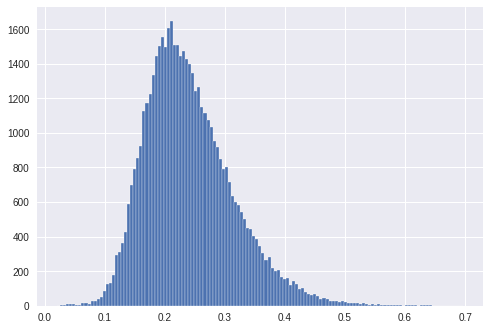

In [134]:
plt.hist(preds[:, 1], bins='auto')

In [135]:
df_test_pred = pd.DataFrame()

df_test_pred['test'] = test_y
df_test_pred['pred'] = preds[:, 1]

In [136]:
df_test_pred.head()

,test,pred
1040719,0,0.227684
2380753,0,0.338303
812824,0,0.187320
2159689,0,0.189973
1534041,0,0.239540


In [137]:
good_pred = df_test_pred[df_test_pred['pred'] > 0.5]
bad_pred = df_test_pred[df_test_pred['pred'] < 0.5]

In [138]:
good_pred.shape, bad_pred.shape

((186, 2), (50173, 2))

In [139]:
good_pred.test.mean(), bad_pred.test.mean()

(0.44623655913978494, 0.3018954417714707)

In [140]:
good_pred[['test', 'pred']].sort_values('pred', ascending=False)[:30]

,test,pred
895784,0,0.696237
927099,1,0.674236
1369896,0,0.667084
2363210,0,0.658947
1616381,0,0.642833
1283559,0,0.642458
265730,0,0.639321
2347097,1,0.636301
1456983,0,0.632764
1616423,0,0.632100


In [141]:
good_pred[['test', 'pred']].sort_values('pred', ascending=False)[:500].test.mean()

0.44623655913978494

In [142]:
bad_pred[['test', 'pred']].sort_values('pred')[:30]

,test,pred
2234806,0,0.020005
2234805,0,0.026808
2234807,0,0.027684
2234803,0,0.029114
2122404,0,0.029593
2122411,0,0.032257
2234877,0,0.033381
2122405,0,0.034444
2122413,0,0.034507
2122412,0,0.035679


In [143]:
bad_pred[['test', 'pred']].sort_values('pred')[:500].test.mean()

0.106

In [144]:
df_test_pred[df_test_pred['test'] == 1].shape, df_test_pred[df_test_pred['test'] == 0].shape

((15230, 2), (35129, 2))

In [145]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [146]:
pos_target_pred = df_test_pred[df_test_pred['test'] == 1].pred
neg_target_pred = df_test_pred[df_test_pred['test'] == 0].pred

pos_target_mean_pred = pos_target_pred.mean()
pos_target_std_pred = pos_target_pred.std()

neg_target_mean_pred = neg_target_pred.mean()
neg_target_std_pred = neg_target_pred.std()

In [147]:
print(pos_target_mean_pred)
print(_tconfint_generic(pos_target_mean_pred, pos_target_std_pred, 
                        len(pos_target_pred) - 1, 0.05, 'two-sided'))

0.2561793787420438
(0.1080523987546449, 0.40430635872944265)


In [148]:
print(neg_target_mean_pred)
print(_tconfint_generic(neg_target_mean_pred, neg_target_std_pred, 
                        len(neg_target_pred) - 1, 0.05, 'two-sided'))

0.23404720331955264
(0.09423541746481628, 0.373858989174289)


In [93]:
df_test_pred[df_test_pred['test'] == 1][['test', 'pred']].sort_values('test', ascending=False)

,test,pred
247503,1,0.214926
1170565,1,0.325402
2352362,1,0.188214
1200243,1,0.261103
1534112,1,0.304725
669897,1,0.404419
1706289,1,0.390919
611416,1,0.371019
306846,1,0.220500
718523,1,0.258471


In [94]:
df_test_pred[df_test_pred['test'] == 0][['test', 'pred']].sort_values('test')

,test,pred
1040719,0,0.244019
2208497,0,0.340311
22571,0,0.297881
2213768,0,0.305009
2281159,0,0.227930
1609231,0,0.263918
1336617,0,0.325175
1181106,0,0.338333
1114702,0,0.300969
545619,0,0.279578


In [98]:
pos_target = df_test_pred[df_test_pred['test'] == 1]
pos_target.shape, sum(pos_target.pred > 0.5), sum(pos_target.pred < 0.5)

((15230, 2), 95, 15135)

In [99]:
neg_target = df_test_pred[df_test_pred['test'] == 0]
neg_target.shape, sum(neg_target.pred > 0.5), sum(neg_target.pred < 0.5)

((35129, 2), 99, 35030)